Universe, the Final Frontier
=================
Apply SparkML+GPU in High-Energy Physics Bigdata Analysis
-------------------------------------------------------

As the famous dialect in StarTrek said, ***Universe is the Final Frontier of Human Beings***. Nowadays, the research focus of data science has covered various aspects of human life, as well as the research of **advanced physics big data**. The usage of advanced data abalysis technique in high-energy physics help scientists accelerate their experiment workload, and finally leading to so many impressive successes all over the world.

## 1. Introduction
### 1.1 Challenge and Motivation
The physics bigdata world is quite different from normal commercial data source. The major differences between physical bigdata and commercial bigdata could be concluded as following:
1. **Complex Data Attributes and Large Instances Number**: 
The high-energy physics experiment collects information of thousands of millions of atomics each time. And each atomic is associated with a complex attribute sets, including velocity, quality and other physics volumn.
2. **High Performance Computation(HPC) and Super Computer Bottleneck**:
In the previous decades, physicians have to depend on super computer to execute the experiment calculation. However, the super computer resources are exceedly limited in US, although the usage cost is quite high for researchers. Additionaly, programming in super computer is totally diffrent from programing in usual servers.
3. **Parallelism and Memory Challenge**:
Faced with a large set of homogeneous data, the parallelism requirement becomes more important in physics bigdata analysis than commercial data analysis. Also the traditional ML library, for example SKlearn, requires to store data in memory before execution. However, the physics data is too large to be put in the memory space of one instance.

Faced with challenges above, following architecture and components would be useful in this problem
1. **Distributed Data Anlysis System**
2. **Commercial Hardware Calculation Cluster**
3. **Heterogeneous Acclerator such as GPU**

Hence, we would propose a ***SparkML+GPU+Cloud*** framework for physics bigdata analysis, in which Cloud Cluster plays a role of infrastructure provider, Spark takes charge of calculation organization, GPU works as heterogenous accelrator. Figure1 indicates the relation between the motivation and architecture.

### 1.2 Tutorial Organization
The discussion of this tutorial would be based on the **HEPMASS** Data Set(2016) from University of Carlifornia, Irvine. It is consisted of 	
10500000 instances (about ***10 million***), each of which owns 28 attributes. 

In the first part of this tutorial we would review the traditional single-node logistic regression model on the dataset. And then the SparkML+GPU+Cloud framework would be applied of which the result would be compared with traditional model. In the third section, we would go through the framework deployment and usage method. And finally further directions would be covered to show the future of this framework.

### 1.3 Special Note
1. This tutorial focus more on **data system architecture**, instead of data algorithm design.
2. It would be better to use the tutorial if you have **previous experience on Spark**, the most famous and popular distributed memory calculation framework. However, **feel free** if you do not know it before, since the main optimization idea is direct and easy to understand.
3. Spark Ecosystem uses java and scala as major programming language, also the system is associated with specific aws image. In other words, you **could not run this notebook directly**. However, I would provide plenty intermediate results and instructions to help you step by step.

## 2. Traditional Logistic Regression Model in HEPMASS
### 2.1 Dataset Explanation and Preprocess
In this model, Machine learning is used in high-energy physics experiments to search for the signatures of exotic particles. These signatures are learned from Monte Carlo simulations of the collisions that produce these particles and the resulting decay products. The goal of this model is to separate particle-producing collisions from a background source. 

Following the command below to download the dataset.
```
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00347/all_train.csv.gz
gzip -d all_train.csv.gz
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00347/all_test.csv.gz
gzip -d all_test.csv.gz
```
The first column is the class label (1 for signal, 0 for background), followed by the 27 normalized features (22 low-level features then 5 high-level features), and a 28th mass feature. The first sample in train dataset looks as following

In [1]:
def printFirstDataSample(csvfile):
    f = open(csvfile)
    indexLine = f.readline()
    dataLine  = f.readline()
    print("Index Line\n",indexLine)
    print("Data Line\n",dataLine)
printFirstDataSample("all_test.csv")

Index Line
 # label,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass

Data Line
 0.000000000000000000e+00,9.439358860254287720e-02,1.275558676570653915e-02,9.119330644607543945e-01,-9.083136916160583496e-02,-2.335745543241500854e-01,-1.054220795631408691e+00,-9.759366512298583984e-01,-1.067278265953063965e+00,-6.138502955436706543e-01,7.542607188224792480e-01,-9.256605505943298340e-01,-5.289512276649475098e-01,1.235263347625732422e+00,8.606486320495605469e-01,-2.320102453231811523e-01,-4.043335020542144775e-01,-1.559396624565124512e+00,-8.154401183128356934e-01,-1.376865267753601074e+00,6.759096682071685791e-02,1.372575879096984863e+00,-5.736824870109558105e-01,-1.368692040443420410e+00,-4.793794453144073486e-01,1.529256343841552734e+00,-5.757816433906555176e-01,-1.290232419967651367e+00,4.999999694824218750e+02



The dataset is too large for a traditional scikit machine learning. Totally running through all datasets takes too mauch time to wait, in order to give you a sense of its efficiency, we would first divide a 10% dataset for experiment

In [2]:
def producePercentSubset(percent,csvfile):
    f = open(csvfile)
    wf = open(csvfile+"."+str(percent),'w')
    if csvfile=="all_train.csv":
        count = percent/100.0 * 7000000
    elif csvfile=="all_test.csv":
        count = percent/100.0 * 3000000
    else:
        print("Invalid csv file")
        return
    indexLine = f.readline()
    wf.write(indexLine)
    while (count>0):
        row = f.readline()
        wf.write(row)
        count -= 1
    
producePercentSubset(10,"all_train.csv")
producePercentSubset(10,"all_test.csv")

After sampling the dataset, the directory organization is as following,
```
ubuntu@ip-172-31-91-240:~/tutorial$ ls -ail
total 8091356
1041180 -rw-rw-r--  1 ubuntu ubuntu 2589223661 Feb  3  2016 all_test.csv
1041078 -rw-rw-r--  1 ubuntu ubuntu 5178435596 Feb  3  2016 all_train.csv
1041079 -rw-rw-r--  1 ubuntu ubuntu  517845288 Mar 26 17:57 all_train.csv.10
1041081 -rw-rw-r--  1 ubuntu ubuntu       8313 Mar 26 17:57 Tutorial.ipynb
```

The ML job in this task is a binary classification problem, and Logistic Regression is one of the recommended methods to classify two clusters of datapoints. Also Logistic Regression is the algorithm suitable for parallel execution, which leading to a quick GPU CUDA implementation.

## 2.2 Logistic Regression Classifier
In this step, we selected the scikit library in python3 to implement the logistic regression.
Following calculation is executed on the Google Cloud Platform with 26GB memory and 4 cores.For each execution longer than 1 minute, an estimated running time would be provided.

Environment Requirement:
1. **Memory**: >=16G (recommended:32G) 
2. **Cores** : >=2  (recommended:4)
3. **GPU**   : N/A
4. **Storage**: >=12G (recommended:30G)

**Note: Only run small dataset, if your server has less than 16GB memory, otherwise, your jupyter notebook would crash without any response**

First, the data is extracted from the trainning set. (*Estimated Time:1.5 min*)

Extract 10% dataset
```
Timestamp before reading:2018-03-27 03:00:03.100450
Timestamp after reading:2018-03-27 03:00:42.233126
```
Extract total dataset
```
Timestamp before reading:2018-03-27 03:21:39.190732
Timestamp after reading:2018-03-27 03:26:55.688656
```

In [5]:
from datetime import datetime
def readData(csvfile):
    f = open(csvfile)
    dataset = []
    targetset = []
    indexLine = f.readline()
    lines = f.readlines()
    for line in lines:
        line = line.strip().split(',')
        tmpset = []
        targetset.append(float(line[0]))
        for i in range(1,len(line)):
            tmpset.append(float(line[i]))
        dataset.append(tmpset)
    return (dataset,targetset)

print("Timestamp before reading:"+str(datetime.now()))
(dataset_train_10,targetset_train_10) = readData("all_train.csv.10")
(dataset_test_10 ,targetset_test_10 ) = readData("all_test.csv.10")
print("Timestamp after reading:"+str(datetime.now()))

'''
#Execute the large dataset only if you have >16G memory
print("Timestamp before reading:"+str(datetime.now()))
(dataset_train,targetset_train) = readData("all_train.csv")
(dataset_test,targetset_test) = readData("all_test.csv")
print("Timestamp after reading:"+str(datetime.now()))
'''

Timestamp before reading:2018-03-27 03:41:05.418181
Timestamp after reading:2018-03-27 03:41:39.894792


'\n#Execute the large dataset only if you have >16G memory\nprint("Timestamp before reading:"+str(datetime.now()))\n(dataset_train,targetset_train) = readData("all_train.csv")\n(dataset_test,targetset_test) = readData("all_test.csv")\nprint("Timestamp after reading:"+str(datetime.now()))\n'

Then ,we import **Logistic Regression Model** from *sklearn* to train this model.

The sample output of 10% dataset:
```
Total Train Size:700000
Timestamp before train:2018-03-27 03:01:09.463669
Timestamp after train:2018-03-27 03:01:24.814552
```
The sample output of total dataset:
```
Total Train Size:7000000
Timestamp before train:2018-03-27 03:34:47.061060
Timestamp after train:2018-03-27 03:37:25.162981
```

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import linear_model, datasets

def LRModelTrain(stepSize,trainSet,targetSet):
    print("Total Train Size:"+str(len(targetSet)))
    print("Timestamp before train:"+str(datetime.now()))
    X = trainSet
    Y = targetSet
    h = stepSize
    lrmodel = linear_model.LogisticRegression(penalty='l2',C=1e5,solver='lbfgs',n_jobs=-1)
    lrmodel.fit(X, Y)
    print("Timestamp after train:"+str(datetime.now()))
    return lrmodel

#lrModel = LRModelTrain(0.01,dataset_train_10,targetset_train_10)

#Execute the large dataset only if you have >16G memory
lrModel = LRModelTrain(0.01,dataset_train,targetset_train)

Total Train Size:7000000
Timestamp before train:2018-03-27 03:34:47.061060
Timestamp after train:2018-03-27 03:37:25.162981


After fetching the lrModel, we use the lrModel to predict

The sample output of predicting 10% target dataset:
```
Timestamp after test:2018-03-27 03:42:10.440674
Timestamp after test:2018-03-27 03:42:10.877418
0.8357166666666667
```

The sample output of predicting total target dataset:
```
Timestamp after test:2018-03-27 03:39:57.233732
Timestamp after test:2018-03-27 03:40:03.268416
0.8359454285714286
```

In [7]:
def LRModelPredict(model,dataset_test,target_test):
    accuracy = model.score(dataset_test,target_test)
    return accuracy

print("Timestamp after test:"+str(datetime.now()))
accuracy = LRModelPredict(lrModel,dataset_test_10,targetset_test_10)
print("Timestamp after test:"+str(datetime.now()))
print(accuracy)

Timestamp after test:2018-03-27 03:42:10.440674
Timestamp after test:2018-03-27 03:42:10.877418
0.8357166666666667


Figure2 indicates the time distribution in this task.Within the dataset size increasing, the trainning time and predicting time increases more quickly than data reading time. The total dataset takes about 10 minutes to complete, while the small dataset takes about 1 minute. 
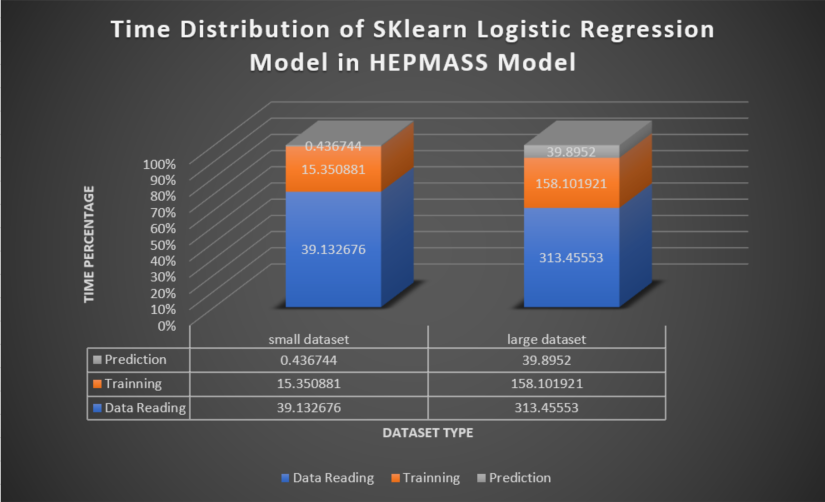

# 2. SparkML Logistic Regression in HEPMASS
## 2.1 SparkML Cluster on GCP
Spark is the most popular distributed calculation framework today, which emplying the power of distributed cluster to fullfill the machine learning tasks. The key idea of SparkML is to divide the large matrix into several block matrixes. And then each block matrix would be scheduled into the task executor, so that a large matrix calculation could be calculated parallely.

Google Cloud Platform provides the **Dataproc** service to help users quickly deploy spark cluster on cloud environment. GCP provides $300 coupon for new users, therefore, don't hesitate to have a try. The power of distributed computing system would definitely impress you. Figure3 indicates the configuration of the spark cluster.
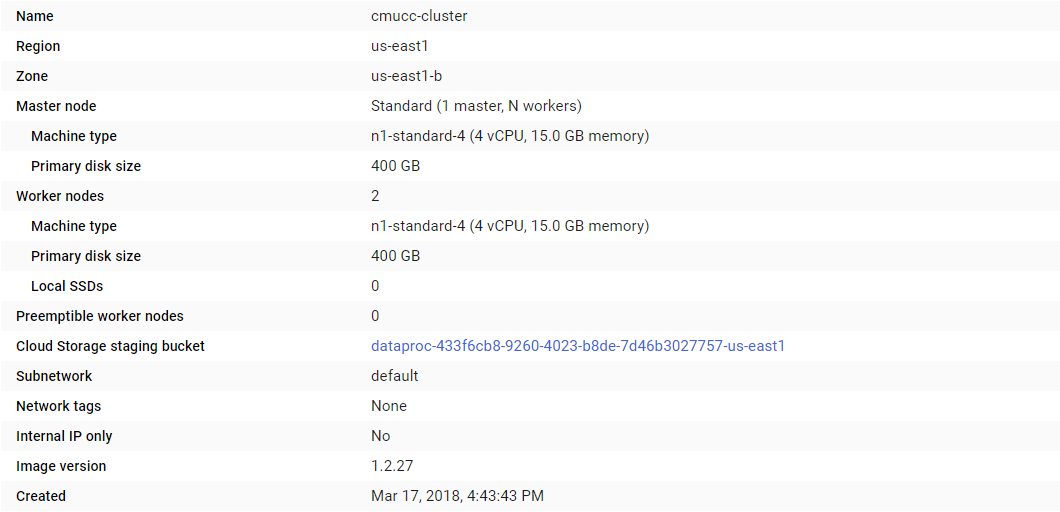


## 2.2 Deploy SparkML Cluster on GCP
After deploying Spark Cluster on GCP, login to the master node and execute the following script.

First, 
```
gsutil cp gs://dataproc-initialization-actions/jupyter/jupyter.sh .
sudo ./jupyter.sh
```
Then, restart Jupyter Notebook and run following python script to import the pyspark dependency.

In [1]:
import findspark
findspark.init()

Finally, run following program to verify the connection

In [3]:
import pyspark
import random
sc = pyspark.SparkContext(appName="Pi")
num_samples = 100000000
def inside(p):
  x, y = random.random(), random.random()
  return x*x + y*y < 1
count = sc.parallelize(range(0, num_samples)).filter(inside).count()
pi = 4 * count / num_samples
print(pi)
sc.stop()

Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: org.apache.hadoop.hdfs.server.namenode.SafeModeException: Cannot create directory /user/shengjil_c4gcp/.sparkStaging/application_1522120727466_0001. Name node is in safe mode.
The reported blocks 0 needs additional 2054 blocks to reach the threshold 0.9990 of total blocks 2057.
The number of live datanodes 0 has reached the minimum number 0. Safe mode will be turned off automatically once the thresholds have been reached. NamenodeHostName:cmucc-cluster-m
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.newSafemodeException(FSNamesystem.java:1392)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.checkNameNodeSafeMode(FSNamesystem.java:1379)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.mkdirs(FSNamesystem.java:2988)
	at org.apache.hadoop.hdfs.server.namenode.NameNodeRpcServer.mkdirs(NameNodeRpcServer.java:1078)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolServerSideTranslatorPB.mkdirs(ClientNamenodeProtocolServerSideTranslatorPB.java:649)
	at org.apache.hadoop.hdfs.protocol.proto.ClientNamenodeProtocolProtos$ClientNamenodeProtocol$2.callBlockingMethod(ClientNamenodeProtocolProtos.java)
	at org.apache.hadoop.ipc.ProtobufRpcEngine$Server$ProtoBufRpcInvoker.call(ProtobufRpcEngine.java:447)
	at org.apache.hadoop.ipc.RPC$Server.call(RPC.java:989)
	at org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:847)
	at org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:790)
	at java.security.AccessController.doPrivileged(Native Method)
	at javax.security.auth.Subject.doAs(Subject.java:422)
	at org.apache.hadoop.security.UserGroupInformation.doAs(UserGroupInformation.java:1836)
	at org.apache.hadoop.ipc.Server$Handler.run(Server.java:2486)

	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.apache.hadoop.ipc.RemoteException.instantiateException(RemoteException.java:121)
	at org.apache.hadoop.ipc.RemoteException.unwrapRemoteException(RemoteException.java:88)
	at org.apache.hadoop.hdfs.DFSClient.primitiveMkdir(DFSClient.java:2529)
	at org.apache.hadoop.hdfs.DFSClient.mkdirs(DFSClient.java:2502)
	at org.apache.hadoop.hdfs.DistributedFileSystem$25.doCall(DistributedFileSystem.java:1155)
	at org.apache.hadoop.hdfs.DistributedFileSystem$25.doCall(DistributedFileSystem.java:1152)
	at org.apache.hadoop.fs.FileSystemLinkResolver.resolve(FileSystemLinkResolver.java:81)
	at org.apache.hadoop.hdfs.DistributedFileSystem.mkdirsInternal(DistributedFileSystem.java:1169)
	at org.apache.hadoop.hdfs.DistributedFileSystem.mkdirs(DistributedFileSystem.java:1144)
	at org.apache.hadoop.fs.FileSystem.mkdirs(FileSystem.java:1914)
	at org.apache.hadoop.fs.FileSystem.mkdirs(FileSystem.java:617)
	at org.apache.spark.deploy.yarn.Client.prepareLocalResources(Client.scala:409)
	at org.apache.spark.deploy.yarn.Client.createContainerLaunchContext(Client.scala:814)
	at org.apache.spark.deploy.yarn.Client.submitApplication(Client.scala:169)
	at org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend.start(YarnClientSchedulerBackend.scala:56)
	at org.apache.spark.scheduler.TaskSchedulerImpl.start(TaskSchedulerImpl.scala:173)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:509)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:236)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.hdfs.server.namenode.SafeModeException): Cannot create directory /user/shengjil_c4gcp/.sparkStaging/application_1522120727466_0001. Name node is in safe mode.
The reported blocks 0 needs additional 2054 blocks to reach the threshold 0.9990 of total blocks 2057.
The number of live datanodes 0 has reached the minimum number 0. Safe mode will be turned off automatically once the thresholds have been reached. NamenodeHostName:cmucc-cluster-m
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.newSafemodeException(FSNamesystem.java:1392)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.checkNameNodeSafeMode(FSNamesystem.java:1379)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.mkdirs(FSNamesystem.java:2988)
	at org.apache.hadoop.hdfs.server.namenode.NameNodeRpcServer.mkdirs(NameNodeRpcServer.java:1078)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolServerSideTranslatorPB.mkdirs(ClientNamenodeProtocolServerSideTranslatorPB.java:649)
	at org.apache.hadoop.hdfs.protocol.proto.ClientNamenodeProtocolProtos$ClientNamenodeProtocol$2.callBlockingMethod(ClientNamenodeProtocolProtos.java)
	at org.apache.hadoop.ipc.ProtobufRpcEngine$Server$ProtoBufRpcInvoker.call(ProtobufRpcEngine.java:447)
	at org.apache.hadoop.ipc.RPC$Server.call(RPC.java:989)
	at org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:847)
	at org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:790)
	at java.security.AccessController.doPrivileged(Native Method)
	at javax.security.auth.Subject.doAs(Subject.java:422)
	at org.apache.hadoop.security.UserGroupInformation.doAs(UserGroupInformation.java:1836)
	at org.apache.hadoop.ipc.Server$Handler.run(Server.java:2486)

	at org.apache.hadoop.ipc.Client.getRpcResponse(Client.java:1486)
	at org.apache.hadoop.ipc.Client.call(Client.java:1432)
	at org.apache.hadoop.ipc.Client.call(Client.java:1342)
	at org.apache.hadoop.ipc.ProtobufRpcEngine$Invoker.invoke(ProtobufRpcEngine.java:227)
	at org.apache.hadoop.ipc.ProtobufRpcEngine$Invoker.invoke(ProtobufRpcEngine.java:116)
	at com.sun.proxy.$Proxy12.mkdirs(Unknown Source)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolTranslatorPB.mkdirs(ClientNamenodeProtocolTranslatorPB.java:579)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invokeMethod(RetryInvocationHandler.java:409)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invokeMethod(RetryInvocationHandler.java:163)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invoke(RetryInvocationHandler.java:155)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invokeOnce(RetryInvocationHandler.java:95)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invoke(RetryInvocationHandler.java:346)
	at com.sun.proxy.$Proxy13.mkdirs(Unknown Source)
	at org.apache.hadoop.hdfs.DFSClient.primitiveMkdir(DFSClient.java:2527)
	... 26 more


In [2]:
import pyspark
